Risultati della rete Unet su immagini di dimensione 256x256 (modello senza preaddestramento e utilizzando come metrica solo accuracy e funzione di loss categorical cross entropy)

In [1]:
# importing required packages...
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from keras.utils import normalize
from tensorflow import keras
from keras.utils import to_categorical
import random
import segmentation_models as sm #pip install segmentation_models
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from tensorflow.keras import layers
import pickle

Segmentation Models: using `keras` framework.


In [2]:
# loading image data...
def image_loader(folder_dir,sx,sy):
    image_dataset = []
    for images in os.listdir(folder_dir):
        path = os.path.join(folder_dir,images)
        image = cv2.imread(path)
        image = cv2.resize(image, (sx,sy))
        image_dataset.append(image)
    return image_dataset

In [3]:
# loading image data...
def mask_loader(folder_dir,sx,sy):
    image_dataset = []
    for images in os.listdir(folder_dir):
        path = os.path.join(folder_dir,images)
        #print(path)
        image = cv2.imread(path, 0)
        #image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (sx,sy))
        #image = Image.fromarray(image)
        #image = np.array(image)
        image_dataset.append(image)
    return image_dataset

In [4]:
parent = os.path.abspath(os.path.join(os.getcwd(), os.pardir)) #parent directory
img_folder = os.path.join("..", "car-segmentation", "images")
masks_folder = os.path.join("..", "car-segmentation", "masks")
n_classes = 5 # class for segmentation
size_x = 128
size_y = 128

image_dataset = image_loader(img_folder,size_x,size_y) # real images...
mask_dataset = mask_loader(masks_folder,size_x,size_y) # masked images...
image_dataset = np.array(image_dataset)
#image_dataset = np.expand_dims(image_dataset, axis = 3) # per creare la giusta struttura
mask_dataset = np.array(mask_dataset)
#Espando la dimensione anche della maschera
mask_dataset_encoded = np.expand_dims(mask_dataset, axis = 3)

#Normalize images (pixel diventano tra 0 e 1)
image_dataset = image_dataset /255. 

In [5]:
#Split training data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset_encoded, test_size = 0.2, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)
print("image Shape:")   
print(X_train.shape)
print(X_test.shape)
print("mask shape:")
print(y_train.shape)
print(y_test.shape)
print(f"Dimensione training set: {len(X_train)}\nDimensione val set: {len(X_val)}\nDimensione test set: {len(X_test)}")
     

image Shape:
(1080, 128, 128, 3)
(338, 128, 128, 3)
mask shape:
(1080, 128, 128, 1)
(338, 128, 128, 1)
Dimensione training set: 1080
Dimensione val set: 270
Dimensione test set: 338


In [6]:
#Le maschere devono avere il formato dell'ultimo layer del modello (128x128x5)
from keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))

test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

val_masks_cat = to_categorical(y_val, num_classes=n_classes)
y_val_cat = val_masks_cat.reshape((y_val.shape[0], y_val.shape[1], y_val.shape[2], n_classes))


In [7]:

#Load previously saved model
from keras.models import load_model
path = os.path.join("..", "UNet1.hdf5")
model = load_model(path) #tf.keras.models.load_model
model.summary()
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

Accuracy ottenuta 0.961815059185028, Loss ottenuta: 0.1038637161254882
Val accuracy: 0.9530852437019348, Val loss: 0.1382921487092971


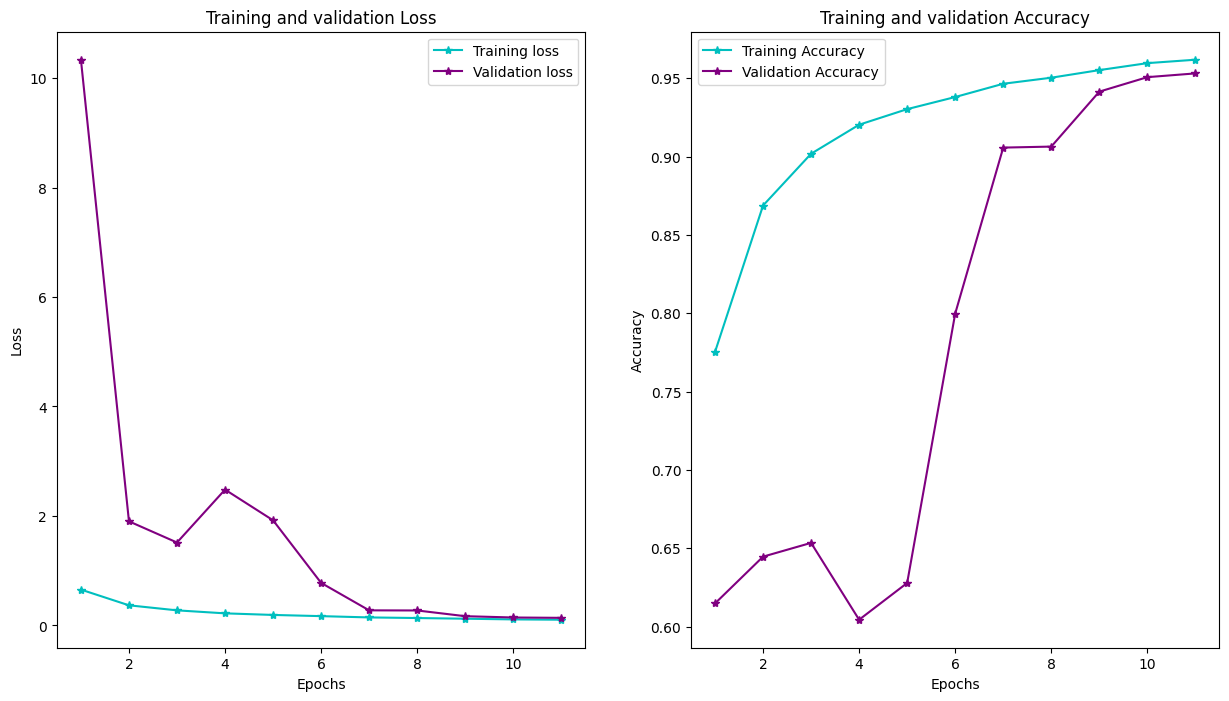

In [42]:
import pandas as pd

log_data = pd.read_csv('UNet1.log', sep=',', engine='python')
log_data = log_data[:-3] #Elimino i risultati dopo early stopping
#plot the training and validation accuracy and loss at each epoch
loss = log_data['loss']
val_loss = log_data['val_loss']
epochs = range(1, len(loss) + 1)

fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(1, 2, 1)
plt.plot(epochs, loss, 'c', marker="*", label='Training loss')
plt.plot(epochs, val_loss, 'purple', marker="*", label='Validation loss')
plt.title('Training and validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


acc = log_data['accuracy']
val_acc = log_data['val_accuracy']
ax = fig.add_subplot(1, 2, 2)
plt.plot(epochs, acc, 'c',  marker="*", label='Training Accuracy')
plt.plot(epochs, val_acc, 'purple', marker="*", label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

last = len(log_data) - 1 #l'ultima riga del file contiene i valori finali del modello
print(f"Accuracy ottenuta {acc[last]}, Loss ottenuta: {loss[last]}\nVal accuracy: {val_acc[last]}, Val loss: {val_loss[last]}")


In [10]:
#Controllo effettivamente il modello sul validation set
val_res = model.evaluate(X_val,y_val_cat)
print(f"Loss ottenuta sul test: {val_res[0]}\nAccuracy ottenuta sul test: {val_res[1]}")

#Predizione del modello sul dataset test
y_pred=model.predict(X_test)
#Argmax controlla il valore maggiore dell'asse indicato e prende solo quello
y_pred_argmax=np.argmax(y_pred, axis=3) 

results = model.evaluate(X_test, y_test_cat)
print(f"Loss ottenuta sul test: {results[0]}\nAccuracy ottenuta sul test: {results[1]}")


9/9 [==============================] - 152s 17s/step - loss: 0.1383 - accuracy: 0.9531
Loss ottenuta sul test: 0.13829214870929718
Accuracy ottenuta sul test: 0.9530852437019348
11/11 [==============================] - 174s 17s/step - loss: 0.1341 - accuracy: 0.9544
Loss ottenuta sul test: 0.13406716287136078
Accuracy ottenuta sul test: 0.9544289708137512


In [34]:
#Per vedere un'unica classe alla volta -> y_pred[n_image][:,:,classe]
classi = ['background', 'car', 'wheel', 'lights', 'windows']
#Using built in keras function
from keras.metrics import MeanIoU
n_classes = 5
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())
#si può calcolare la mean IoU per ogni classe
# target_class_ids indicates the class/classes you want to calculate IoU on
for i in range(5):
    loss = tf.keras.metrics.IoU(num_classes=5, target_class_ids=[i])
    loss.update_state(y_test, y_pred_argmax)
    print("Risultato per la classe", classi[i] ,": ",loss.result().numpy())

Mean IoU = 0.7540756
Risultato per la classe background :  0.9631957
Risultato per la classe car :  0.8651486
Risultato per la classe wheel :  0.8850267
Risultato per la classe lights :  0.32888484
Risultato per la classe windows :  0.72812194


1/1 [==============================] - 0s 324ms/step


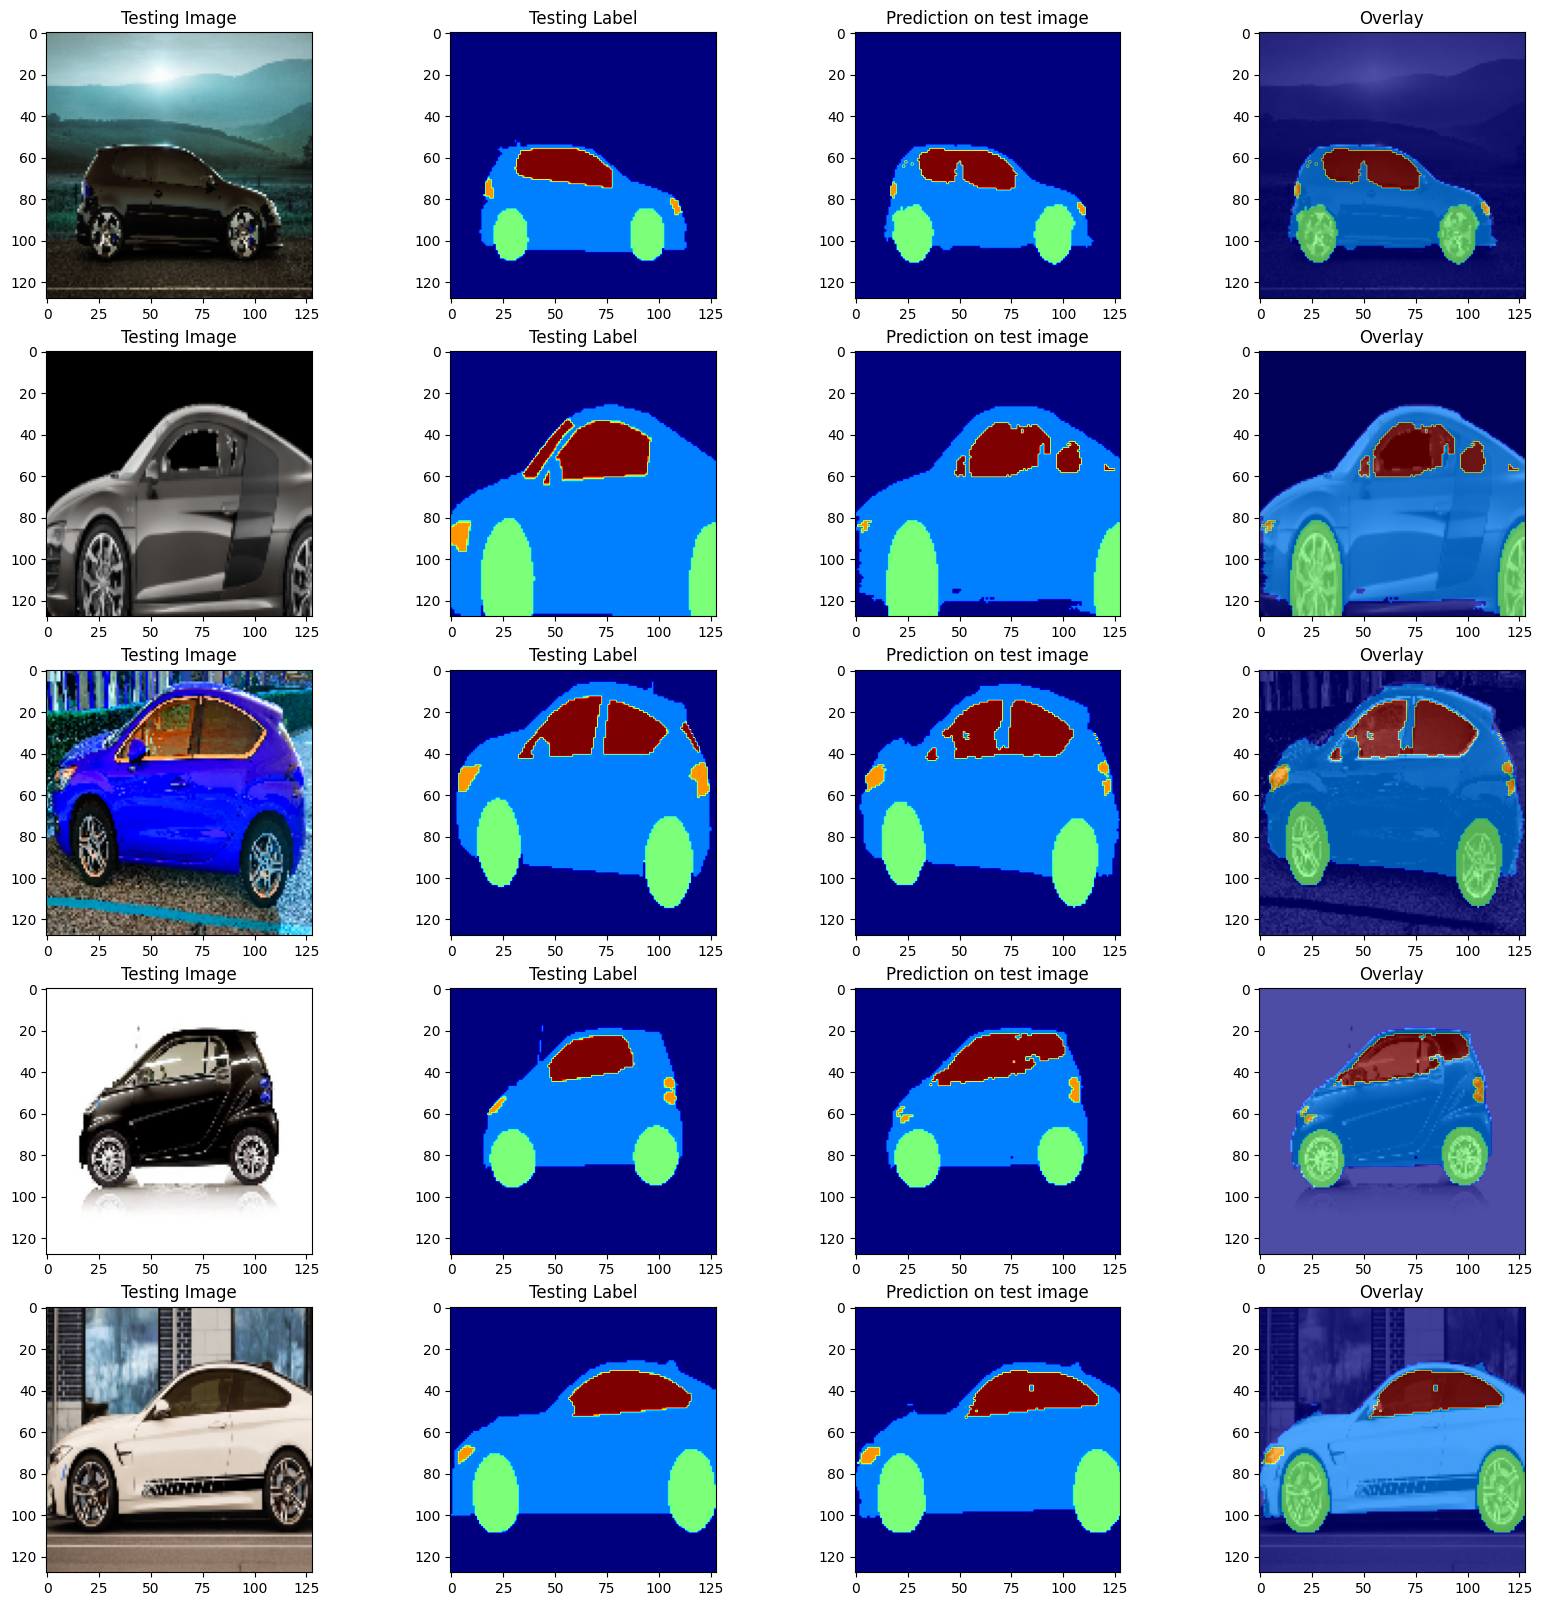

In [20]:
import random

fig = plt.figure(figsize=(20, 20))

for i in range(5):
    test_img_number = random.randint(0, len(X_test)-1)
    test_img = X_test[test_img_number]
    test_img_input = np.expand_dims(test_img,0)
    ground_truth=y_test[test_img_number]
    prediction = (model.predict(test_img_input))
    predicted_img=np.argmax(prediction, axis=3)[0,:,:]

    ax = fig.add_subplot(5,4,i*4+1)
    plt.title('Testing Image')
    plt.imshow(test_img, cmap='gray')
    
    ax = fig.add_subplot(5,4,i*4+2)
    plt.title('Testing Label')
    plt.imshow(ground_truth[:,:,0], cmap='jet')
    
    ax = fig.add_subplot(5,4,i*4+3)
    plt.title('Prediction on test image')
    plt.imshow(predicted_img, cmap='jet')
    
    ax = fig.add_subplot(5,4,i*4+4)
    plt.title('Overlay')
    plt.imshow(test_img[:,:,0], cmap='gray')
    plt.imshow(predicted_img, cmap='jet', alpha=0.7)
    #plt.show()